In [1]:
import numpy as np
import pandas as pd
import os
from numpy import sqrt, power
from scipy import pi, exp, log, optimize
from scipy.integrate import quad
from scipy.stats import norm
import time
from sklearn import tree

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

np.random.seed(3)

In [2]:
# fourier transform and helper funcitions

def heston_phi(z, tau, v, vbar, lamb, eta, rho, lambdaJ, alphaJ, deltaJ,vJJ):
    a0=lamb-rho*eta*z*1j
    gamma=power(eta**2*(z**2+z*1j)+a0*a0, 0.5)
    G=(a0-gamma)/(a0+gamma)
    a1=v/eta/eta*((1-exp(-gamma*tau))/(1-G*exp(-gamma*tau)))*(a0-gamma)
    a2=lamb*vbar/eta/eta*(tau*(a0-gamma)-2*log((1-G*exp(-gamma*tau))/(1-G))) #c*vbar
    if lambdaJ == 0:
        return exp(a1+a2)
    I=1.0
    if vJJ != 0:
        integrand=lambda t: np.exp(vJJ/eta/eta*((1-exp(-gamma*t))/(1-G*exp(-gamma*t)))*(a0-gamma))
        I=(1.0/tau)*(quad(lambda t: integrand(t).real, 0, tau, limit=500)[0]+1j*quad(lambda t: integrand(t).imag, 0, tau, limit=500)[0])
    psi=tau*lambdaJ*(exp(1j*z*alphaJ-0.5*z**2*deltaJ**2)*I-1-1j*z*(exp(alphaJ+0.5*deltaJ**2)-1))
    return exp(a1+a2+psi)
    

def heston_phi_call(k, tau, v, vbar, lambd, eta, rho, lambdaJ, alphaJ, deltaJ,vJJ, AL):
    integrand=lambda z: (exp(-z*k*1j)*heston_phi(z-(AL+1)*1j, tau, v, vbar, lambd, eta, rho, lambdaJ, alphaJ, deltaJ,vJJ)/(AL**2+AL-z**2+1j*(2*AL+1)*z)).real
    return quad(integrand, 0, 500, limit=250)[0]

def heston_call(S,K,tau,v,vbar,lambd,eta,rho, lambdaJ, alphaJ, deltaJ,vJJ,r=0,divYield=0):
    dampFac=0.5
    k=log(K/S)-r*tau+divYield*tau
    integral=heston_phi_call(k, tau, v, vbar, lambd, eta,rho, lambdaJ, alphaJ, deltaJ,vJJ,dampFac)
    return exp(-divYield*tau)*S*exp(-dampFac*k)*integral/pi
    
def heston_phi_put(k, tau, v, vbar, lambd, eta, rho, lambdaJ, alphaJ, deltaJ,vJJ, AL):
    integrand=lambda z: (exp(-z*k*1j)*heston_phi(z-(-AL+1)*1j, tau, v, vbar, lambd, eta, rho, lambdaJ, alphaJ, deltaJ,vJJ)/(AL**2-AL-z**2+1j*(-2*AL+1)*z)).real
    return quad(integrand, 0, 500, limit=250)[0]

def heston_put(S,K,tau,v,vbar,lambd,eta,rho, lambdaJ, alphaJ, deltaJ, vJJ,r=0,divYield=0):
    dampFac=3
    k=log(K/S)-r*tau+divYield*tau
    integral=heston_phi_put(k, tau, v, vbar, lambd, eta,rho, lambdaJ, alphaJ, deltaJ, vJJ,dampFac)
    return exp(-divYield*tau)*S*exp(dampFac*k)*integral/pi   
    
    
def bsprice(S, K, T, sigma, isCall=True):
    d1=(np.log(S/K)+(0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    if isCall:
        return S*norm.cdf(d1,0,1)-K*norm.cdf(d2,0,1)
    else:
        return K*norm.cdf(-d2,0,1)-S*norm.cdf(-d1,0,1)
        

def implied_vol(target_value, S, K, T, isCall=True,l=0.01,u=0.5):
    return optimize.brentq(lambda sig: bsprice(S,K,T,sig,isCall)-target_value,l,u)

In [3]:
#check fourier transform via mc

V0, Vbar, kappa, alpha, rho = 0.2**2, 0.2**2, 2, 0.2, -0.5
lambdaJ, alphaJ, deltaJ=0,-0.1,0.1
vJJ=0

n_sims=250000
n_t=365
dt=1.0/(2*365)
sqrtDt=dt**0.5
divYield=0.1

def simulatePath():
    C=np.zeros(n_sims)
    V=V0*np.ones(n_sims)
    for _ in range(2*n_t):
        W1=np.random.randn(n_sims)
        W2=rho*W1+(1-rho**2)**0.5*np.random.randn(n_sims)
        W=np.random.randn(n_sims)
        U=np.random.uniform(size=(n_sims))

        C=-divYield*dt+C+np.sqrt(V)*W1*sqrtDt-0.5*V*dt-lambdaJ *(exp(alphaJ+0.5*deltaJ**2)-1)*dt
        V=np.maximum(0.0001**2, V+kappa*(Vbar-V)*dt+alpha*np.sqrt(V)*W2*sqrtDt)
        #jumps
        C=C+np.where(U<dt*lambdaJ, alphaJ+deltaJ*W, 0)
        V=V+np.where(U<dt*lambdaJ, vJJ, 0)
    return np.exp(C)


print("check FT via MC")
print("Heston")
S=simulatePath()
T=n_t/365.0
K=1.05
payoff=np.maximum(S-K,0)
print("MC:", np.mean(payoff))
print("conf interval:", np.mean(payoff)-2*np.std(payoff)/n_sims**0.5, np.mean(payoff)+2*np.std(payoff)/n_sims**0.5)
print("FT: ", heston_call(1,K,T,V0,Vbar,kappa,alpha,rho,lambdaJ,alphaJ,deltaJ,vJJ,0,divYield))

lambdaJ=0.1
print("Bates")
S=simulatePath()
payoff=np.maximum(S-K,0)
print("MC:", np.mean(payoff))
print("conf interval:", np.mean(payoff)-2*np.std(payoff)/n_sims**0.5, np.mean(payoff)+2*np.std(payoff)/n_sims**0.5)
print("FT: ", heston_call(1,K,T,V0,Vbar,kappa,alpha,rho,lambdaJ,alphaJ,deltaJ,vJJ,0,divYield))

vJJ=0.1
print("Matytsin")
S=simulatePath()
payoff=np.maximum(S-K,0)
print("MC:", np.mean(payoff))
print("conf interval:", np.mean(payoff)-2*np.std(payoff)/n_sims**0.5, np.mean(payoff)+2*np.std(payoff)/n_sims**0.5)
print("FT: ", heston_call(1,K,T,V0,Vbar,kappa,alpha,rho,lambdaJ,alphaJ,deltaJ,vJJ,0,divYield))

check FT via MC
Heston
MC: 0.021796744805308244
conf interval: 0.021553322736368275 0.022040166874248212
FT:  0.02186091401608878
Bates
MC: 0.023126461258469833
conf interval: 0.022872479505773438 0.02338044301116623
FT:  0.022982658737547967
Matytsin
MC: 0.024167414463576647
conf interval: 0.02390208437447651 0.024432744552676786
FT:  0.02424749073303889


In [4]:
win_vt = 20
sigma_vt=0.1

n_sims=100000

n_d=365+win_vt
n_t=n_d

dt=1.0/365
sqrtDt=dt**0.5

#102
filename=os.path.join(os.getcwd(), "vt_data_params_x_y200.csv")
filenameCapped=os.path.join(os.getcwd(), "vt_data_params_x_y200_capped.csv")

lambdaJ, alphaJ, deltaJ=0.2,-0.1,0.1
vJJ=0.1

In [5]:
def getRandomParams():
    V0=np.random.uniform(0.15, 0.35) #in vol
    VBar=(V0+min(0.05, max(-0.05, np.random.normal(0, 0.025))))**2
    V0=V0**2
    kappa=np.random.uniform(1,4)
    alpha=np.random.uniform(0.0, 2*VBar*kappa)**0.5
    rho=0
    while(rho<-0.95 or rho>-0.05):
        rho=-0.6+0.15*np.random.normal()
    divYield = np.random.uniform(-0.03, 0.03)
    return [V0, VBar, kappa, alpha, rho, divYield]


def getSkews(params):
    v,vbar,lambd,eta,rho, divYield = params
    Ks = [0.95, 1, 1.05]
    Ts = [1/12.0, 3/12.0, 1]
    ret=[]
    for lambdaJ_used, vJJ_used in [[0,0], [lambdaJ,0], [lambdaJ, vJJ]]:
        for T in Ts:
            for K in Ks:
                F=exp(-divYield*T)
                p = heston_call(1,K,T,v,vbar,lambd,eta,rho,lambdaJ_used,alphaJ,deltaJ,vJJ_used,0,divYield)
                ret.append(implied_vol(p, F, K, T))
    return ret


def getIVs(params):
    v,vbar,lambd,eta,rho,divYield = params
    Ks = [0.95, 1, 1.05]
    Ts = [0.08, 0.25, 1]
    ret=[]
    for T in Ts:
        for K in Ks:
            F=exp(-divYield*T)
            p = heston_call(F,K,T,v,vbar,lambd,eta,rho)
            print(T,K,p,implied_vol(p, F, K, T))


def generatePath(params):
    V0, Vbar, kappa, alpha, rho, divYield = params
    
    HC=np.zeros((n_sims, n_t+1))
    BC=np.zeros((n_sims, n_t+1))
    MC=np.zeros((n_sims, n_t+1))
    HV=V0*np.ones(n_sims)
    MV=V0*np.ones(n_sims)
    for j in range(n_t):
        W1=np.random.randn(n_sims)
        W2=rho*W1+(1-rho**2)**0.5*np.random.randn(n_sims)
        W=np.random.randn(n_sims)
        U=np.random.uniform(size=(n_sims))

        HC[:,1+j]=HC[:,j]-divYield*dt+np.sqrt(HV)*W1*sqrtDt-0.5*HV*dt
        BC[:,1+j]=BC[:,j]-divYield*dt+np.sqrt(HV)*W1*sqrtDt-0.5*HV*dt-\
                    lambdaJ*(exp(alphaJ+0.5*deltaJ**2)-1)*dt+np.where(U<dt*lambdaJ, alphaJ+deltaJ*W, 0)
        MC[:,1+j]=MC[:,j]-divYield*dt+np.sqrt(MV)*W1*sqrtDt-0.5*MV*dt-\
                    lambdaJ*(exp(alphaJ+0.5*deltaJ**2)-1)*dt+np.where(U<dt*lambdaJ, alphaJ+deltaJ*W, 0)
        HV=np.maximum(0.0001**2, HV+kappa*(Vbar-HV)*dt+alpha*np.sqrt(HV)*W2*sqrtDt)
        MV=np.maximum(0.0001**2, MV+kappa*(Vbar-MV)*dt+alpha*np.sqrt(MV)*W2*sqrtDt)+\
                    np.where(U<dt*lambdaJ, vJJ, 0)
    
    return np.exp(HC), np.exp(BC), np.exp(MC)


def computeVT(S, maxExp=None):
    n_sims=S.shape[0]
    ret = S[:,1:]/S[:,:-1]-1
    logRetSqr=np.power(np.log(1+ret),2)
    
    sigma_real = np.zeros((n_sims, n_d+1))
    vt=np.ones((n_sims, n_d+1))
    for j in range(win_vt, n_d+1):
        if j > win_vt+1:
            vt[:,j]=vt[:,j-1]*(1+np.multiply(lastExp, ret[:,j-1]))
            
        if j > win_vt:
            lastExp=sigma_vt/sigma_real[:,j-1]
            if maxExp:
                lastExp=np.minimum(lastExp, maxExp)
                
        sigma_real[:,j]=np.sqrt(365/win_vt*np.sum(logRetSqr[:,j-win_vt:j], axis=1))

    return vt


def computeVTStats(vt, f=1):
    Ks = np.array([0.95, 1, 1.05])
    ret=[]
    for j in [win_vt+30*i for i in range(1,13)]:
        T=(j-win_vt)/365.0
        for K in Ks:
            isCall = K>=1
            payoff = np.maximum((1 if isCall else -1)*(vt[:,j]-K),0)
            p = np.mean(payoff)
            
            iv = implied_vol(p, 1, K, T, isCall,0.08,0.15)
            
            s = np.std(payoff)/n_sims**0.5
            s = s/f**0.5
            iv2 = implied_vol(p+2*s, 1, K, T, isCall,0.08,0.15)
            
            ret = ret + [iv, iv2]
    return ret

In [ ]:
def simulatePathBS(sigma,n_t,n_sims):
    dt=1.0/365.0
    C=np.zeros((n_t+1,n_sims))
    for i in range(n_t):
        C[i+1,:]=C[i,:]+sigma * dt**0.5 * np.random.randn(n_sims) - 0.5*sigma**2*dt
    return np.exp(C)

vts=[]
for sig in np.linspace(0.1, 0.3, 21):
    S=simulatePathBS(sig,365+win_vt,500000).T
    vt=computeVT(S)
    p=np.mean(np.maximum(vt[:,-1]-1,0))
    vts.append(implied_vol(p,1,1,1))

In [ ]:
plt.plot(np.linspace(0.1, 0.3, 21), vts)
plt.xlabel("vol in Black scholes model")
plt.ylabel("implied vol of option on vol target")
plt.savefig("vt_bs.pdf")

In [ ]:
x=np.linspace(0.01, 0.5, 50)
plt.plot(x, np.sqrt(np.square(x)+0.1)-x)
plt.ylabel("jump in vol in Matytsin model")
plt.xlabel("level of instantaneous vol before jump")
plt.savefig("mat_j.pdf")

In [ ]:
fig, axs = plt.subplots(3, sharex=True)
for i,T, kl, ku, tt in [[0,1.0/12.0, 0.9, 1.1, "expiry in 1m"],
                     [1,3.0/12.0, 0.85, 1.15, "expiry in 3m"],
                     [2,1.0, 0.75, 1.25, "expiry in 1y"]]:
    x=np.linspace(kl,ku,int((ku-kl)*100+1))
    ivh=[]
    ivb=[]
    ivm=[]
    for s in x:
        if s<1:
            ph=heston_put(1,s,T,V0,Vbar,kappa,alpha,rho,0,alphaJ,deltaJ,0)
            pb=heston_put(1,s,T,V0,Vbar,kappa,alpha,rho,lambdaJ,alphaJ,deltaJ,0)
            pm=heston_put(1,s,T,V0,Vbar,kappa,alpha,rho,lambdaJ,alphaJ,deltaJ,vJJ)
        else:
            ph=heston_call(1,s,T,V0,Vbar,kappa,alpha,rho,0,alphaJ,deltaJ,0)
            pb=heston_call(1,s,T,V0,Vbar,kappa,alpha,rho,lambdaJ,alphaJ,deltaJ,0)
            pm=heston_call(1,s,T,V0,Vbar,kappa,alpha,rho,lambdaJ,alphaJ,deltaJ,vJJ)
        ivh.append(implied_vol(ph, 1, s, T, isCall=s>=1))
        ivb.append(implied_vol(pb, 1, s, T, isCall=s>=1))
        ivm.append(implied_vol(pm, 1, s, T, isCall=s>=1))

    axs[i].plot(x, ivh, label="Heston")
    axs[i].plot(x, ivb, label="Bates")
    axs[i].plot(x, ivm, label="Matytsin")
    axs[i].legend()
    axs[i].set_title(tt)
fig.set_size_inches(10, 10)
fig.savefig('hbm_ivs1.pdf')

In [ ]:
x=[0.95, 1.0, 1.05]
ivh2=[]
ivb2=[]
ivm2=[]
for i,T, kl, ku, tt in [[0,1.0/12.0, 0.9, 1.1, "expiry in 1m"],
                     [1,3.0/12.0, 0.85, 1.15, "expiry in 3m"],
                     [2,1.0, 0.75, 1.25, "expiry in 1y"]]:
    for s in x:
        if s<1:
            ph=heston_put(1,s,T,V0,Vbar,kappa,alpha,rho,0,alphaJ,deltaJ,0)
            pb=heston_put(1,s,T,V0,Vbar,kappa,alpha,rho,lambdaJ,alphaJ,deltaJ,0)
            pm=heston_put(1,s,T,V0,Vbar,kappa,alpha,rho,lambdaJ,alphaJ,deltaJ,vJJ)
        else:
            ph=heston_call(1,s,T,V0,Vbar,kappa,alpha,rho,0,alphaJ,deltaJ,0)
            pb=heston_call(1,s,T,V0,Vbar,kappa,alpha,rho,lambdaJ,alphaJ,deltaJ,0)
            pm=heston_call(1,s,T,V0,Vbar,kappa,alpha,rho,lambdaJ,alphaJ,deltaJ,vJJ)
        ivh2.append(implied_vol(ph, 1, s, T, isCall=s>=1))
        ivb2.append(implied_vol(pb, 1, s, T, isCall=s>=1))
        ivm2.append(implied_vol(pm, 1, s, T, isCall=s>=1))
for iv in [ivh2, ivb2, ivm2]:
    print((iv[2]-iv[0])/0.1, (iv[2+3]-iv[0+3])/0.1, (iv[2+6]-iv[0+6])/0.1)
    print((iv[2]-2*iv[1]+iv[0])/0.05/0.05, (iv[2+3]-2*iv[1+3]+iv[0+3])/0.05/0.05, (iv[2+6]-2*iv[1+6]+iv[0+6])/0.05/0.05)

In [12]:
def priceStd(vt):
    Ks = np.array([0.95, 1, 1.05])
    ret=[]
    s=[]
    for j in [win_vt+30, win_vt+90, win_vt+360]:
        T=(j-win_vt)/365.0
        for K in Ks:
            isCall = K>=1
            payoff = np.maximum((1 if isCall else -1)*(vt[:,j]-K),0)
            s.append(np.std(payoff)/n_sims**0.5)
            ret.append(np.mean(payoff))
    return ret, s

def getVols(p, f=1,dy=0):
    ret=[]
    i=0
    Ks = np.array([0.95, 1, 1.05])
    for _ in range(3):
        for j in [win_vt+30, win_vt+90, win_vt+360]:
            T=(j-win_vt)/365.0
            for K in Ks:
                isCall = K>=1
                F=exp(-dy*T)
                iv = implied_vol(p[i], F, K, T, isCall,0.08,0.15)
                s = p[27+i]/f**0.5
                iv2 = implied_vol(p[i]+2*s, F, K, T, isCall,0.08,0.15)
                ret = ret + [iv, iv2]
                i=i+1
    return ret

    
n_samples = 250
f=5
caps=[1e5, 1.0]
for ii in range(n_samples):
    try:
        goodParams = False
        while not goodParams:
            params = getRandomParams()
            X = getSkews(params)
            goodParams = X[2]-X[0]<0 and X[2]-2*X[1]+X[0]>0

        p=np.zeros((len(caps),54))
        for i in range(f):
            H, B, M = generatePath(params)
            for k in range(len(caps)):
                for S, j in [[H,0],[B,1],[M,2]]:
                    vt=computeVT(S,caps[k])
                    price, s = priceStd(vt)
                    p[k,j*9:(j+1)*9]=(p[k,j*9:(j+1)*9]*i+price)/(i+1)
                    if i == 0 :
                        p[k,27+j*9:27+(j+1)*9]=s
                    
        Y = getVols(p[0,:], f,params[-1])
        YCapped = getVols(p[1,:], f,params[-1])

        with open(filename,'a') as fil:
            fil.write(",".join([str(z) for z in params+X+Y])+"\n")
        with open(filenameCapped,'a') as fil:
            fil.write(",".join([str(z) for z in params+X+YCapped])+"\n")
            
        print(ii, ":", params,"at", time.asctime( time.localtime(time.time()) ))
    except:
        print(ii, ": FAIL", params, "at", time.asctime( time.localtime(time.time()) ) )

0 : [0.03329420699084227, 0.03413721591718963, 3.2114253297356976, 0.3981118661096002, -0.5448511190907619, 0.023064987833187903] at Fri Oct 30 21:00:47 2020
1 : [0.07260896905918199, 0.0691313722766094, 1.3756338609826009, 0.274945214614526, -0.44092054156540317, 0.0022730356653445777] at Fri Oct 30 21:11:01 2020
2 : [0.0988144253424983, 0.13182683980824528, 3.748209534129908, 0.8608179362508301, -0.4799157297465363, -0.016803631899152485] at Fri Oct 30 21:17:08 2020
3 : [0.07488224339646331, 0.08005793872423009, 2.193170814509146, 0.5784260106813621, -0.6182318994423256, -0.013114855823988112] at Fri Oct 30 21:21:48 2020
4 : [0.0645240559689286, 0.05069988287502811, 1.1246376591846603, 0.296852526685529, -0.3766328816734382, 0.020370379647491728] at Fri Oct 30 21:26:28 2020
5 : [0.07231504421365248, 0.08614893266766191, 1.1675180932002795, 0.11704282477247348, -0.6284917311909056, 0.02279547607352561] at Fri Oct 30 21:31:07 2020
6 : [0.06080634580492935, 0.05073457048896128, 1.854126

52 : [0.04176181350128254, 0.0382907008188259, 1.6473214439519914, 0.23276260630064372, -0.7015271138723722, 0.029814806876797988] at Sat Oct 31 01:38:10 2020
53 : [0.058523384633901755, 0.04147439277289116, 3.5725280276560554, 0.4607766971241595, -0.5442070930957817, -0.014926303406689214] at Sat Oct 31 01:46:24 2020
54 : [0.04350558519446745, 0.033186031916675914, 2.402854665227107, 0.2786306580441634, -0.6171733781099991, 0.0015745209244559938] at Sat Oct 31 01:51:05 2020
55 : [0.027204354957933507, 0.038701646718600574, 2.3666333386816576, 0.18129300630255882, -0.38443844882834366, -0.02931646459985712] at Sat Oct 31 01:55:49 2020
56 : [0.1175859854281164, 0.1284890397773335, 2.3867064287747373, 0.15012775951927151, -0.5401374633069902, -0.0005978301338630497] at Sat Oct 31 02:00:29 2020
57 : [0.06373650870106727, 0.05273089727341515, 1.5712952831141287, 0.13107742045843318, -0.6285290828042478, -0.009700855699430824] at Sat Oct 31 02:05:13 2020
58 : [0.09569575090373798, 0.1194741

104 : [0.022863056267080687, 0.02396738856922364, 3.368994566066087, 0.31233476387375503, -0.6445401813532444, -0.029453928315292942] at Sat Oct 31 06:42:43 2020
105 : [0.09942655178480683, 0.08984465657658959, 1.5290323478691272, 0.3155310002999084, -0.3542634613839881, 0.009229548970206128] at Sat Oct 31 06:47:28 2020
106 : [0.06228148154304532, 0.06711735395896148, 3.700987179556334, 0.2746492827306644, -0.5738094166983447, -0.00617781298545517] at Sat Oct 31 06:52:08 2020
107 : [0.08555609225222388, 0.06999431821941188, 2.177001737861797, 0.3141241504343126, -0.5018832249466898, 0.01909399424268448] at Sat Oct 31 06:56:48 2020
108 : [0.06589506139130023, 0.0686415655475848, 2.020088464614217, 0.49402940297608683, -0.6983729563587454, -0.021484204806980413] at Sat Oct 31 07:04:22 2020
109 : [0.060802224201943526, 0.04226820747406662, 2.1546529673812675, 0.34782625304492293, -0.4437396091670126, 0.01541788498876634] at Sat Oct 31 07:09:02 2020
110 : [0.029742200476521027, 0.022165143

155 : [0.04005203883150835, 0.05348420992103378, 3.6249432635610246, 0.34311897579126477, -0.6837306949274893, -0.019828699074171875] at Sat Oct 31 10:50:22 2020
156 : [0.08691599783230393, 0.06305319110727339, 1.7972934354552983, 0.4243967371537035, -0.5576060517066407, -0.013307764772289708] at Sat Oct 31 10:55:46 2020
157 : [0.07587926924575947, 0.08467399259790462, 3.966718795798111, 0.24980189408697492, -0.5277041302244622, -0.006679647267315542] at Sat Oct 31 11:01:31 2020
158 : [0.10972101776431561, 0.12030697613574713, 2.892540247783584, 0.4797771051685122, -0.6186040778308017, -0.021686150581169454] at Sat Oct 31 11:06:24 2020
159 : [0.12012502796197214, 0.0995696954758659, 3.577614353107933, 0.6037405785247313, -0.5771639531502469, 0.0064063363205389065] at Sat Oct 31 11:11:37 2020
160 : [0.08770597021778805, 0.08698529407493757, 1.127377918719262, 0.43445739515828996, -0.5132414781415678, 0.01528769317068461] at Sat Oct 31 11:16:24 2020
161 : [0.04053907697868619, 0.04394175

207 : [0.024392884557957815, 0.026120215160461556, 3.580051265514726, 0.33532701457878694, -0.3924602857607482, 0.02775042857267545] at Sat Oct 31 16:04:41 2020
208 : [0.0876445184895429, 0.06053970156905801, 3.8759649412875454, 0.6483084196573164, -0.6953004841844362, -0.011967317003262614] at Sat Oct 31 16:09:22 2020
209 : [0.05221857989355439, 0.050959314170413356, 1.2541746234926865, 0.33964216579225553, -0.5501675041238643, -0.01848289492299198] at Sat Oct 31 16:14:35 2020
210 : [0.07819370517226087, 0.1086568425449272, 3.4465751775138953, 0.5926060633433015, -0.6314471573034122, 0.0006368269533631038] at Sat Oct 31 16:27:58 2020
211 : [0.04768404951855292, 0.03895525375661959, 1.2320387282230958, 0.136032258359292, -0.6176500096870536, -0.013572023024602881] at Sat Oct 31 16:32:40 2020
212 : [0.05584683587427791, 0.06277534869678567, 3.069054280431654, 0.518181134595462, -0.45080457594342926, 0.02832442345409828] at Sat Oct 31 16:37:20 2020
213 : [0.0473424397409543, 0.0379347554

In [26]:
c=["v0","vbar","kappa","alpha","rho"]
h=["Xsig"+str(t)+s for t in [1,3,12] for s in ["d","m","u"]]
c=c+[x+m for m in ["H","B","M"] for x in h]
h=[st+str(t)+s for t in [1,3,12] for s in ["d","m","u"] for st in ["sig", "errsig"] ]
c=c+[x+m for m in ["H","B","M"] for x in h]
d=pd.read_csv(filenameCapped, names=c)
d.head()

,v0,vbar,kappa,alpha,rho,Xsig1dH,Xsig1mH,Xsig1uH,Xsig3dH,Xsig3mH,...,sig3mM,errsig3mM,sig3uM,errsig3uM,sig12dM,errsig12dM,sig12mM,errsig12mM,sig12uM,errsig12uM
0,0.026737,0.031695,3.786185,0.361994,-0.576285,0.178141,0.163271,0.150258,0.175873,0.163840,...,0.112041,0.112498,0.107687,0.108014,0.116030,0.116412,0.114489,0.114987,0.113599,0.114003
1,0.077203,0.051918,3.969559,0.506933,-0.681861,0.282562,0.267656,0.253137,0.266040,0.252997,...,0.107281,0.107719,0.103484,0.103796,0.111590,0.111947,0.111291,0.111775,0.110966,0.111359
2,0.046855,0.071001,1.348846,0.398248,-0.620716,0.230797,0.216807,0.203674,0.230669,0.217859,...,0.109548,0.109995,0.105284,0.105604,0.112946,0.113309,0.111466,0.111951,0.110946,0.111338
3,0.050210,0.059337,1.722704,0.440454,-0.710068,0.239058,0.222343,0.205675,0.235140,0.219771,...,0.109338,0.109779,0.104351,0.104659,0.113742,0.114107,0.112499,0.112985,0.111861,0.112254
4,0.106800,0.086260,1.402765,0.413753,-0.495000,0.330823,0.322761,0.315463,0.323483,0.315784,...,0.106035,0.106473,0.103836,0.104151,0.108809,0.109155,0.108464,0.108937,0.108164,0.108547


In [27]:
modelNames=["H","B","M"]
Xd={}
Yd={}
for m in modelNames:
    d["Xskew1"+m]=(d["Xsig1u"+m]-d["Xsig1d"+m])/0.1
    d["Xskew3"+m]=(d["Xsig3u"+m]-d["Xsig3d"+m])/0.1
    d["Xskew12"+m]=(d["Xsig12u"+m]-d["Xsig12d"+m])/0.1
    d["Yskew1"+m]=(d["sig1u"+m]-d["sig1d"+m])/0.1
    d["Yskew3"+m]=(d["sig3u"+m]-d["sig3d"+m])/0.1
    d["Yskew12"+m]=(d["sig12u"+m]-d["sig12d"+m])/0.1
    d["Xconv1"+m]=(d["Xsig1u"+m]+d["Xsig1d"+m]-2*d["Xsig1m"+m])/0.05/0.05
    d["Xconv3"+m]=(d["Xsig3u"+m]+d["Xsig3d"+m]-2*d["Xsig3m"+m])/0.05/0.05
    d["Xconv12"+m]=(d["Xsig12u"+m]+d["Xsig12d"+m]-2*d["Xsig12m"+m])/0.05/0.05
    d["Yconv1"+m]=(d["sig1u"+m]+d["sig1d"+m]-2*d["sig1m"+m])/0.05/0.05
    d["Yconv3"+m]=(d["sig3u"+m]+d["sig3d"+m]-2*d["sig3m"+m])/0.05/0.05
    d["Yconv12"+m]=(d["sig12u"+m]+d["sig12d"+m]-2*d["sig12m"+m])/0.05/0.05
    Xd[m]=d[["Xsig1m"+m,"Xsig3m"+m,"Xsig12m"+m,"Xskew1"+m,"Xskew3"+m,"Xskew12"+m,"Xconv1"+m,"Xconv3"+m,"Xconv12"+m]]
    Yd[m]=d[["sig1m"+m,"sig3m"+m,"sig12m"+m,"Yskew1"+m,"Yskew3"+m,"Yskew12"+m,"Yconv1"+m,"Yconv3"+m,"Yconv12"+m,"errsig1m"+m,"errsig3m"+m,"errsig12m"+m]]

In [20]:
for m in modelNames:
    print(m)
    a=(100*Xd[m]).describe()
    print(a.loc[['min', '25%', '50%', '75%', 'max']]) #.to_latex()

H
       Xsig1mH    Xsig3mH   Xsig12mH    Xskew1H    Xskew3H   Xskew12H  \
min  14.704109  13.885194  12.258837 -42.441346 -35.076314 -19.279349   
25%  20.185594  19.906490  19.476410 -28.977877 -25.430133 -14.698008   
50%  25.168465  24.662441  24.124128 -23.870494 -21.302258 -12.696632   
75%  29.967137  29.246885  28.717377 -19.243748 -17.429600 -10.588596   
max  34.641851  34.585716  35.595208  -5.829676  -5.185547  -2.819468   

        Xconv1H     Xconv3H   Xconv12H  
min    0.040290    1.278847   7.603807  
25%   23.844043   25.182632  18.489689  
50%   41.867132   39.722800  21.630863  
75%   69.111832   59.066833  25.978202  
max  322.642879  177.373545  46.594551  
B
       Xsig1mB    Xsig3mB   Xsig12mB    Xskew1B    Xskew3B   Xskew12B  \
min  15.316038  14.797559  13.581396 -48.416333 -36.321382 -18.436419   
25%  20.741935  20.683858  20.412890 -32.724373 -26.382316 -14.551281   
50%  25.671950  25.332556  24.899339 -27.801878 -23.013198 -12.708595   
75%  30.431040  29.

In [29]:
for m in modelNames:
    print(m)
    b=(100*Yd[m]).describe()
    #print(b.loc[['50%']].to_latex())
    print(b)

H
           sig1mH      sig3mH     sig12mH     Yskew1H     Yskew3H    Yskew12H  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean    10.293633   10.508529   10.626034  -14.022608   -5.008873   -0.685419   
std      0.075610    0.099353    0.138758    4.111682    1.384475    0.691960   
min     10.059133   10.168117   10.074424  -24.997413   -9.804155   -3.601042   
25%     10.252130   10.450036   10.547584  -16.889413   -5.876286   -0.938619   
50%     10.297913   10.504133   10.635338  -13.932293   -5.017398   -0.537139   
75%     10.340036   10.566785   10.720901  -11.134184   -4.084789   -0.219307   
max     10.499696   10.824595   11.008533   -3.259930   -1.058172    0.822358   

          Yconv1H     Yconv3H    Yconv12H   errsig1mH   errsig3mH  errsig12mH  
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000  
mean   -71.813793  -29.473430   -2.475444   10.334707   10.551823   10.672383  
std     41.799991   18.99163

In [84]:
Hm=[0.105139,0.108962,0.112418]
Hmu=[0.105554,0.109412,0.112915]
Hu=[0.096863,0.105580,0.112160]
Huu=[0.097195,0.105901,0.112562]
Hd=[0.115402,0.112279,0.112956]
Hdu=[0.115849,0.112651,0.113327]

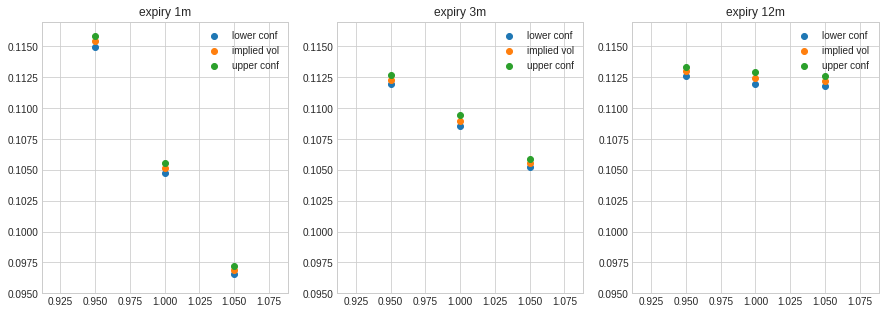

In [134]:
fig, axs = plt.subplots(1,3)
tt=["expiry 1m","expiry 3m","expiry 12m"]
for i in range(3):
    x=[0.95,1,1.05]
    yd=[2*Hd[i]-Hdu[i],2*Hm[i]-Hmu[i],2*Hu[i]-Huu[i]]
    ym=[Hd[i],Hm[i],Hu[i]]
    yu=[Hdu[i],Hmu[i],Huu[i]]
    axs[i].scatter(x, yd, label="lower conf")
    axs[i].scatter(x, ym, label="implied vol")
    axs[i].scatter(x, yu, label="upper conf")
    axs[i].set_ylim([0.095,0.117])
    axs[i].legend()
    axs[i].set_title(tt[i])
fig.set_size_inches(15, 5)
fig.savefig('conf_mat.pdf')

In [6]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [7]:
Xv={}
Yv={}
for m in modelNames:
    Xv[m]=Xd[m].values
    Yv[m]=Yd[m]["sig12m"+m].values

In [8]:
XtestF={}
ytestF={}
XtrainF={}
ytrainF={}
XvalidF={}
yvalidF={}
for i, m in zip(range(3),modelNames):
    XtrainF[m], XtestF[m], ytrainF[m], ytestF[m] = train_test_split(Xv[m], Yv[m], test_size=0.20, random_state=41+2*i)
    XvalidF[m], XtestF[m], yvalidF[m], ytestF[m] = train_test_split(XtestF[m], ytestF[m], test_size=0.50, random_state=42+2*i)

In [9]:
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit_transform(XtrainF["M"])
XtrainT={}
XtestT={}
XvalidT={}
for m in modelNames:
    XtrainT[m]=mm_scaler.transform(XtrainF[m])
    XtestT[m]=mm_scaler.transform(XtestF[m])
    XvalidT[m]=mm_scaler.transform(XvalidF[m])

In [33]:
nF=2
for m in modelNames:
    print("model",m)
    pftr=PolynomialFeatures(nF).fit_transform(XtrainT[m])
    pfva=PolynomialFeatures(nF).fit_transform(XvalidT[m])
    for l in [0, 1e-7, 1e-6, 1e-5, 1e-4]:
        if l>0:
            poly_model = Lasso(alpha=l, max_iter=50000)
        else:
            poly_model = LinearRegression(fit_intercept=False)
        poly_model.fit(pftr, ytrainF[m])
        yfit = poly_model.predict(pfva)
        eps=100*100*np.sqrt(mean_squared_error(yfit,yvalidF[m]))
        numF=sum([abs(f)>1e-5 for f in poly_model.coef_])
        print(l, eps, numF)

model H
0 2.5295862703775436 55
1e-07 2.6795894453288294 18
1e-06 3.2428956130452153 10
1e-05 4.401158390981031 5
0.0001 11.419894353361054 1
model B
0 2.936829047409863 55
1e-07 3.1332746006055254 24
1e-06 3.9417863306165426 16
1e-05 6.391704707422773 8
0.0001 16.37870306368613 3
model M
0 3.608783380850934 55
1e-07 3.188018022411076 26
1e-06 4.261612476760686 15
1e-05 8.321168208736918 6
0.0001 12.067941637125836 4


In [35]:
best_model={}
for m in modelNames:
    print("model",m)
    pftr=PolynomialFeatures(nF).fit_transform(XtrainT[m])
    best_model[m] = Lasso(alpha=1e-7, max_iter=50000)
    best_model[m].fit(pftr, ytrainF[m])

model H
model B
model M


In [47]:
for m in modelNames:
    print("model",m)
    pfte=PolynomialFeatures(nF).fit_transform(XtestT[m])
    yfit = best_model[m].predict(pfte)
    print(np.sqrt(mean_squared_error(yfit,ytestF[m])))

model H
0.00022918654831578355
model B
0.00034480843814887964
model M
0.00031079344134610156


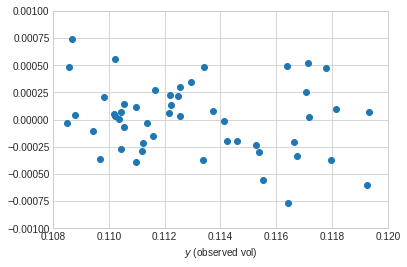

In [46]:
pfva=PolynomialFeatures(nF).fit_transform(XvalidT["M"])
yfit = best_model["M"].predict(pfva)
plt.scatter(yvalidF["M"],yfit-yvalidF["M"])
plt.xlim(0.108,0.12)
plt.ylim(-0.001,0.001)
plt.xlabel("$y$ (observed vol)")
#plt.ylabel("$y-\hat{y}$ (observed vol - predicted vol)")
plt.savefig('residuals.pdf')

In [32]:
for m in modelNames:
    print("model",m)
    for fl in [[0],[3],[6],[0,3],[0,6],[3,6],[0,3,6]]:
        for i in range(len(fl)):
            htrain=XtrainT[m][:,fl[i]:fl[i]+3]
            hvalid=XvalidT[m][:,fl[i]:fl[i]+3]
            if i==0:
                ftrain=htrain
                fvalid=hvalid
            else:
                ftrain=np.hstack([ftrain,htrain])
                fvalid=np.hstack([fvalid,hvalid])
        pftr=PolynomialFeatures(1).fit_transform(ftrain)
        pfva=PolynomialFeatures(1).fit_transform(fvalid)
        
        poly_model = LinearRegression(fit_intercept=False)
        poly_model.fit(pftr, ytrainF[m])
        yfit = poly_model.predict(pfva)
        eps=np.sqrt(mean_squared_error(yfit,yvalidF[m]))
        print(fl, eps)
        print(100*poly_model.coef_)

model H
[0] 0.0006291058087504329
[ 10.70701811   9.52000622 -14.78886554   5.39385138]
[3] 0.000627938091368269
[10.97001001 -0.56403076 -0.21341605  0.46881644]
[6] 0.000980142294265932
[10.6158615  -3.17211806  2.85132421 -0.63940533]
[0, 3] 0.0005760558228506363
[ 10.95508567   8.36497777 -12.76571307   4.47566531  -1.25701052
   1.23191123  -0.25303465]
[0, 6] 0.0006143149792807974
[ 10.63450511   8.64057314 -13.31247575   4.82338983   0.33883955
  -0.09024533   0.17125366]
[3, 6] 0.000442765219645147
[10.85854037 -0.18029931 -0.25786124  0.02185012 -0.98887843  1.40122257
 -0.25956711]
[0, 3, 6] 0.0003972133507197291
[10.89081196  3.66775938 -5.36664638  1.77768744 -1.00396607  0.85171851
 -0.30128341 -0.39612748  0.84720747 -0.03696021]
model B
[0] 0.001628239154105086
[ 11.98551423  13.43423067 -20.11935909   5.52532311]
[3] 0.0029180408679098237
[12.197129   -5.91349112  5.70196958 -1.07727117]
[6] 0.0018123052749118513
[10.93438331  3.98430615 -2.48498804  0.80216217]
[0, 3] 

In [52]:
XtestTall=np.vstack([XtestT["H"],XtestT["B"],XtestT["M"]])
pfte=PolynomialFeatures(nF).fit_transform(XtestTall)
df=pd.DataFrame()
for m in modelNames:
    df[m] = best_model[m].predict(pfte)
df.describe()

,H,B,M
count,150.000000,150.000000,150.000000
mean,0.107948,0.114277,0.112991
std,0.001210,0.003415,0.002642
min,0.105183,0.107816,0.107817
25%,0.107239,0.111829,0.111050
50%,0.107886,0.113687,0.112737
75%,0.108702,0.116193,0.114519
max,0.111947,0.124245,0.120471
